In [2]:
import pandas as pd
import numpy as np
import json
from datetime import date
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from math import sqrt
#import lifelines
from lifelines import KaplanMeierFitter

%load_ext autoreload
%autoreload 2

#Lifelines does not currently align the at risk counts with the axis. This was manually adjusted in the code and imported below.
#from lifelines.plotting import add_at_risk_counts

# Trends

This code creates graphs that track the overall reporting of trial over time. We can create a snapshot of FDAAA compliance for any date in our ClinicalTrials.gov archive (dating to February 2018). See the notebook or script "Processing Raw FDAAA Data" for the code to generate a processed file for any archived csv with 1 trial in JSON format per row. As it is somewhat lengthy to process all these files, this is run in seperate code and CSVs of the processed data are saved for data sharing and quicker future data handling/analysis.

Once we have a processed dataset for each date in our analysis with only appliable trials, we can measure how many are due, if/when they reported, how late they were on any given date, etc.

In [5]:
#This cell pulls out counts for each month based on the processed data.

#Lists for statistics of interest
reported_by_month_all = []
reported_by_month_on_time = []
due_by_month  = []
reporting_prcts = []
overdue_by_month = []

#QA data manually scraped for due trials before this data was included in the ClinicalTrials.gov XML in May 2018.
#qa = pd.read_csv('C:/Users/ndevito/Desktop/FDAAA Implementation Data/qa.csv')
qa = pd.read_csv('/Users/nicholasdevito/Dropbox/fdaaa_analysis_data/qa.csv')
qa.submitted_to_regulator = pd.to_datetime(qa['submitted_to_regulator'])
grouped = qa.groupby(['registry_id']).min()

#Dates of scrapes used, on or as close to mid-month available.
scrape_dates = [date(2018,3,15), date(2018,4,16), date(2018,5,15), date(2018,6,15), date(2018,7,16), date(2018,8,13), 
                date(2018,9,14), date(2018,10,15), date(2018,11,15), date(2018,12,14), date(2019,1,15),
                date(2019,2,15), date(2019,3,15), date(2019,4,15), date(2019,5,15),date(2019,6,7)]

#Location of previously processed CSVs. Edit to your local path from the data available at [Figshare link]
#path = 'C:/Users/ndevito/Desktop/FDAAA Implementation Data/Processed CSVs'
path = '/Users/nicholasdevito/Desktop/fdaaa analysis/processed data'
files = os.listdir(path)
files.sort()
files.remove('.DS_Store')

#Importing custom function to get count data
from programs.summary_data import get_summary_data

#This loops through all the processed files, and produces the relevant statistics of interest for each date. 
#Data from before the availability of QA details in the XML are handled using 'qa' data we manually maintained through scrapes
#Data is processed via the `get_summary_data` function imported above
for file, scrape_date in zip(files, scrape_dates):
    df = pd.read_csv(os.path.join(path, file), low_memory=False)
    df['due_date'] = pd.to_datetime(df['due_date'])
    df['results_first_submitted_date'] = pd.to_datetime(df['results_first_submitted_date'])
    df['first_results_submission_any'] = pd.to_datetime(df['first_results_submission_any'])
    numerator, denominator, number_on_time = get_summary_data(df,scrape_date,grouped)
    reported_by_month_all.append(numerator)
    due_by_month.append(denominator)
    overdue_by_month.append(denominator - numerator)
    reporting_prcts.append(round((numerator/denominator)*100,2))
    reported_by_month_on_time.append(number_on_time)

In [6]:
#Function to get CIs.

def ci_calc(nums, denoms):
    cis = []
    z = 1.96
    for n,d in zip(nums,denoms):
        p = n/d
        se = (p*(1-p))/d
        ci = z * sqrt(se)
        cis.append(ci*100)
    return cis

line_errors = ci_calc(reported_by_month_all, due_by_month)

In [7]:
#if we want error bars on the bar chart

bar_errors = ci_calc(overdue_by_month, due_by_month)

overdue_errors = []
for be, o in zip(bar_errors, overdue_by_month):
    overdue_errors.append(o * (be/100))

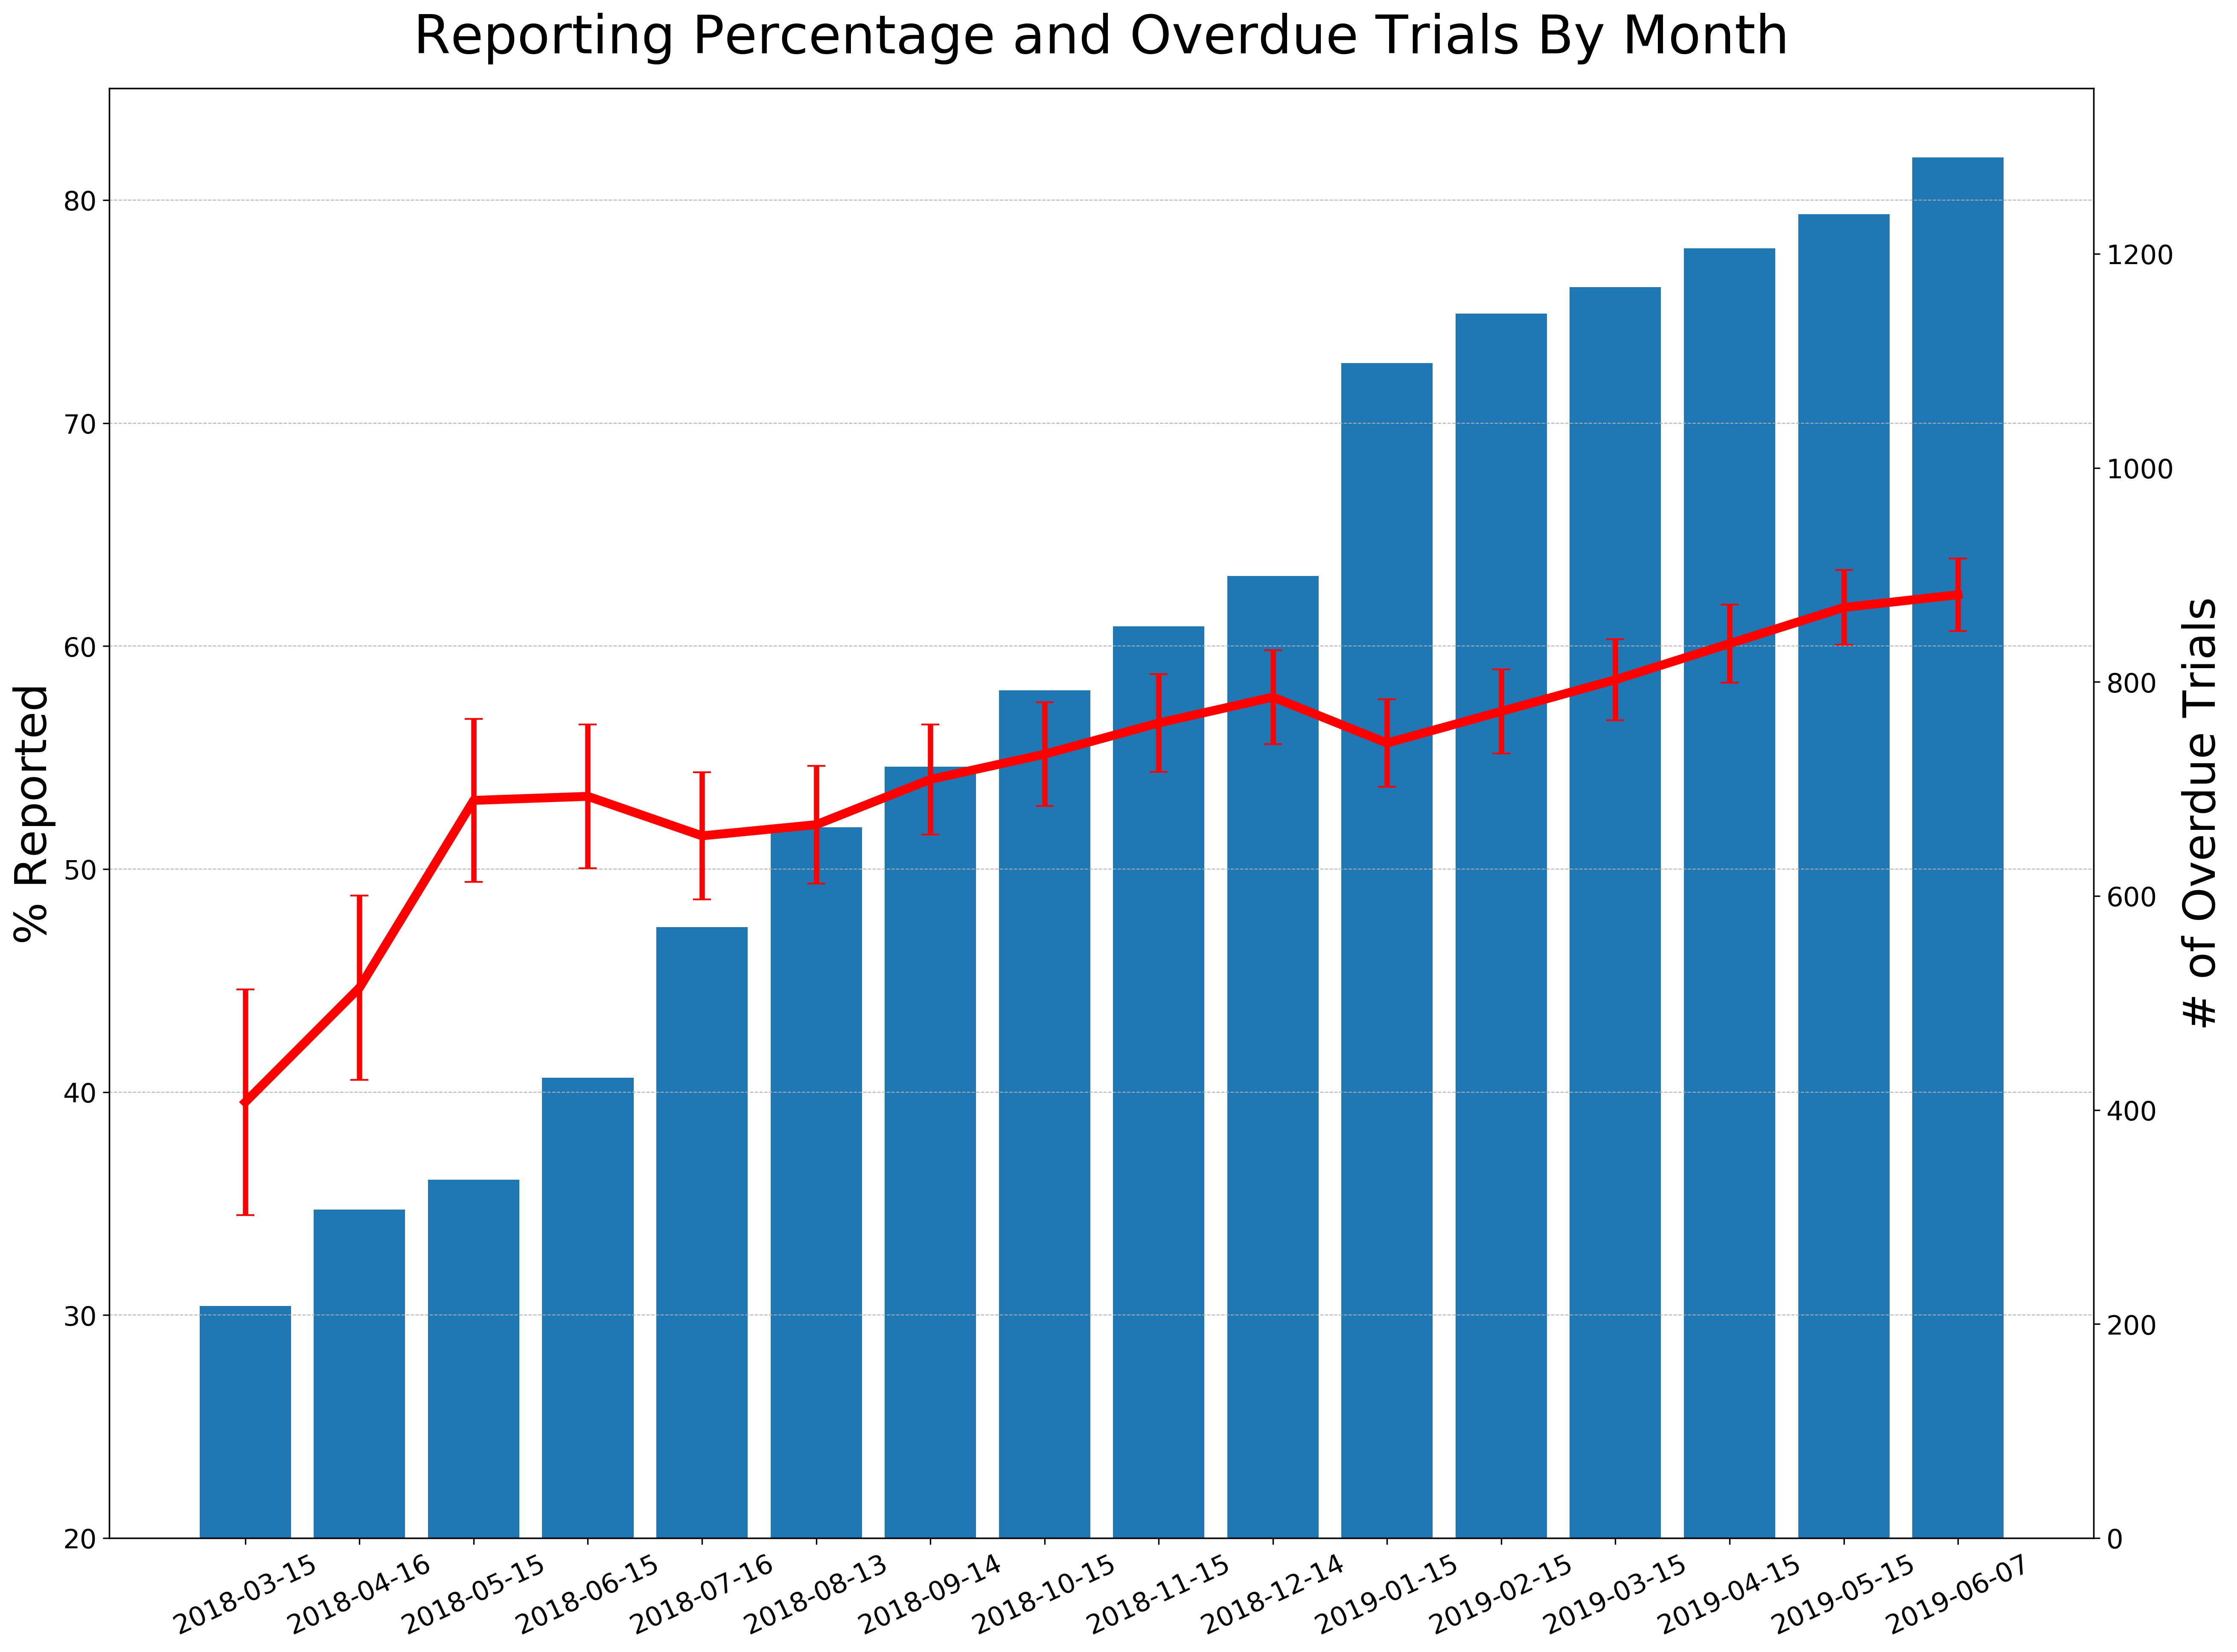

In [8]:
#creates graph of reporting percentage as a line over a bar graph of overdue trials by month

fig, ax = plt.subplots(figsize=(20,15), dpi = 300)
index = np.arange(len(scrape_dates))
plt.errorbar(index,reporting_prcts, yerr=line_errors, elinewidth = 3, capsize=5, c = 'red', lw=5)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('% Reported', fontsize=25)
plt.xticks(rotation=25)
plt.title("Reporting Percentage and Overdue Trials By Month", pad = 20, fontsize = 30)
ax.set_ylim([20,85])

ax2 = plt.twinx()
ax2.set_axisbelow(True)
ax.yaxis.grid(linestyle='--', linewidth=.5, zorder=ax.get_zorder()-10)
ax2.bar(index, overdue_by_month, capsize=5, tick_label = scrape_dates)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('# of Overdue Trials', fontsize=25)

ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
plt.show()
#plt.savefig('trends.svg')

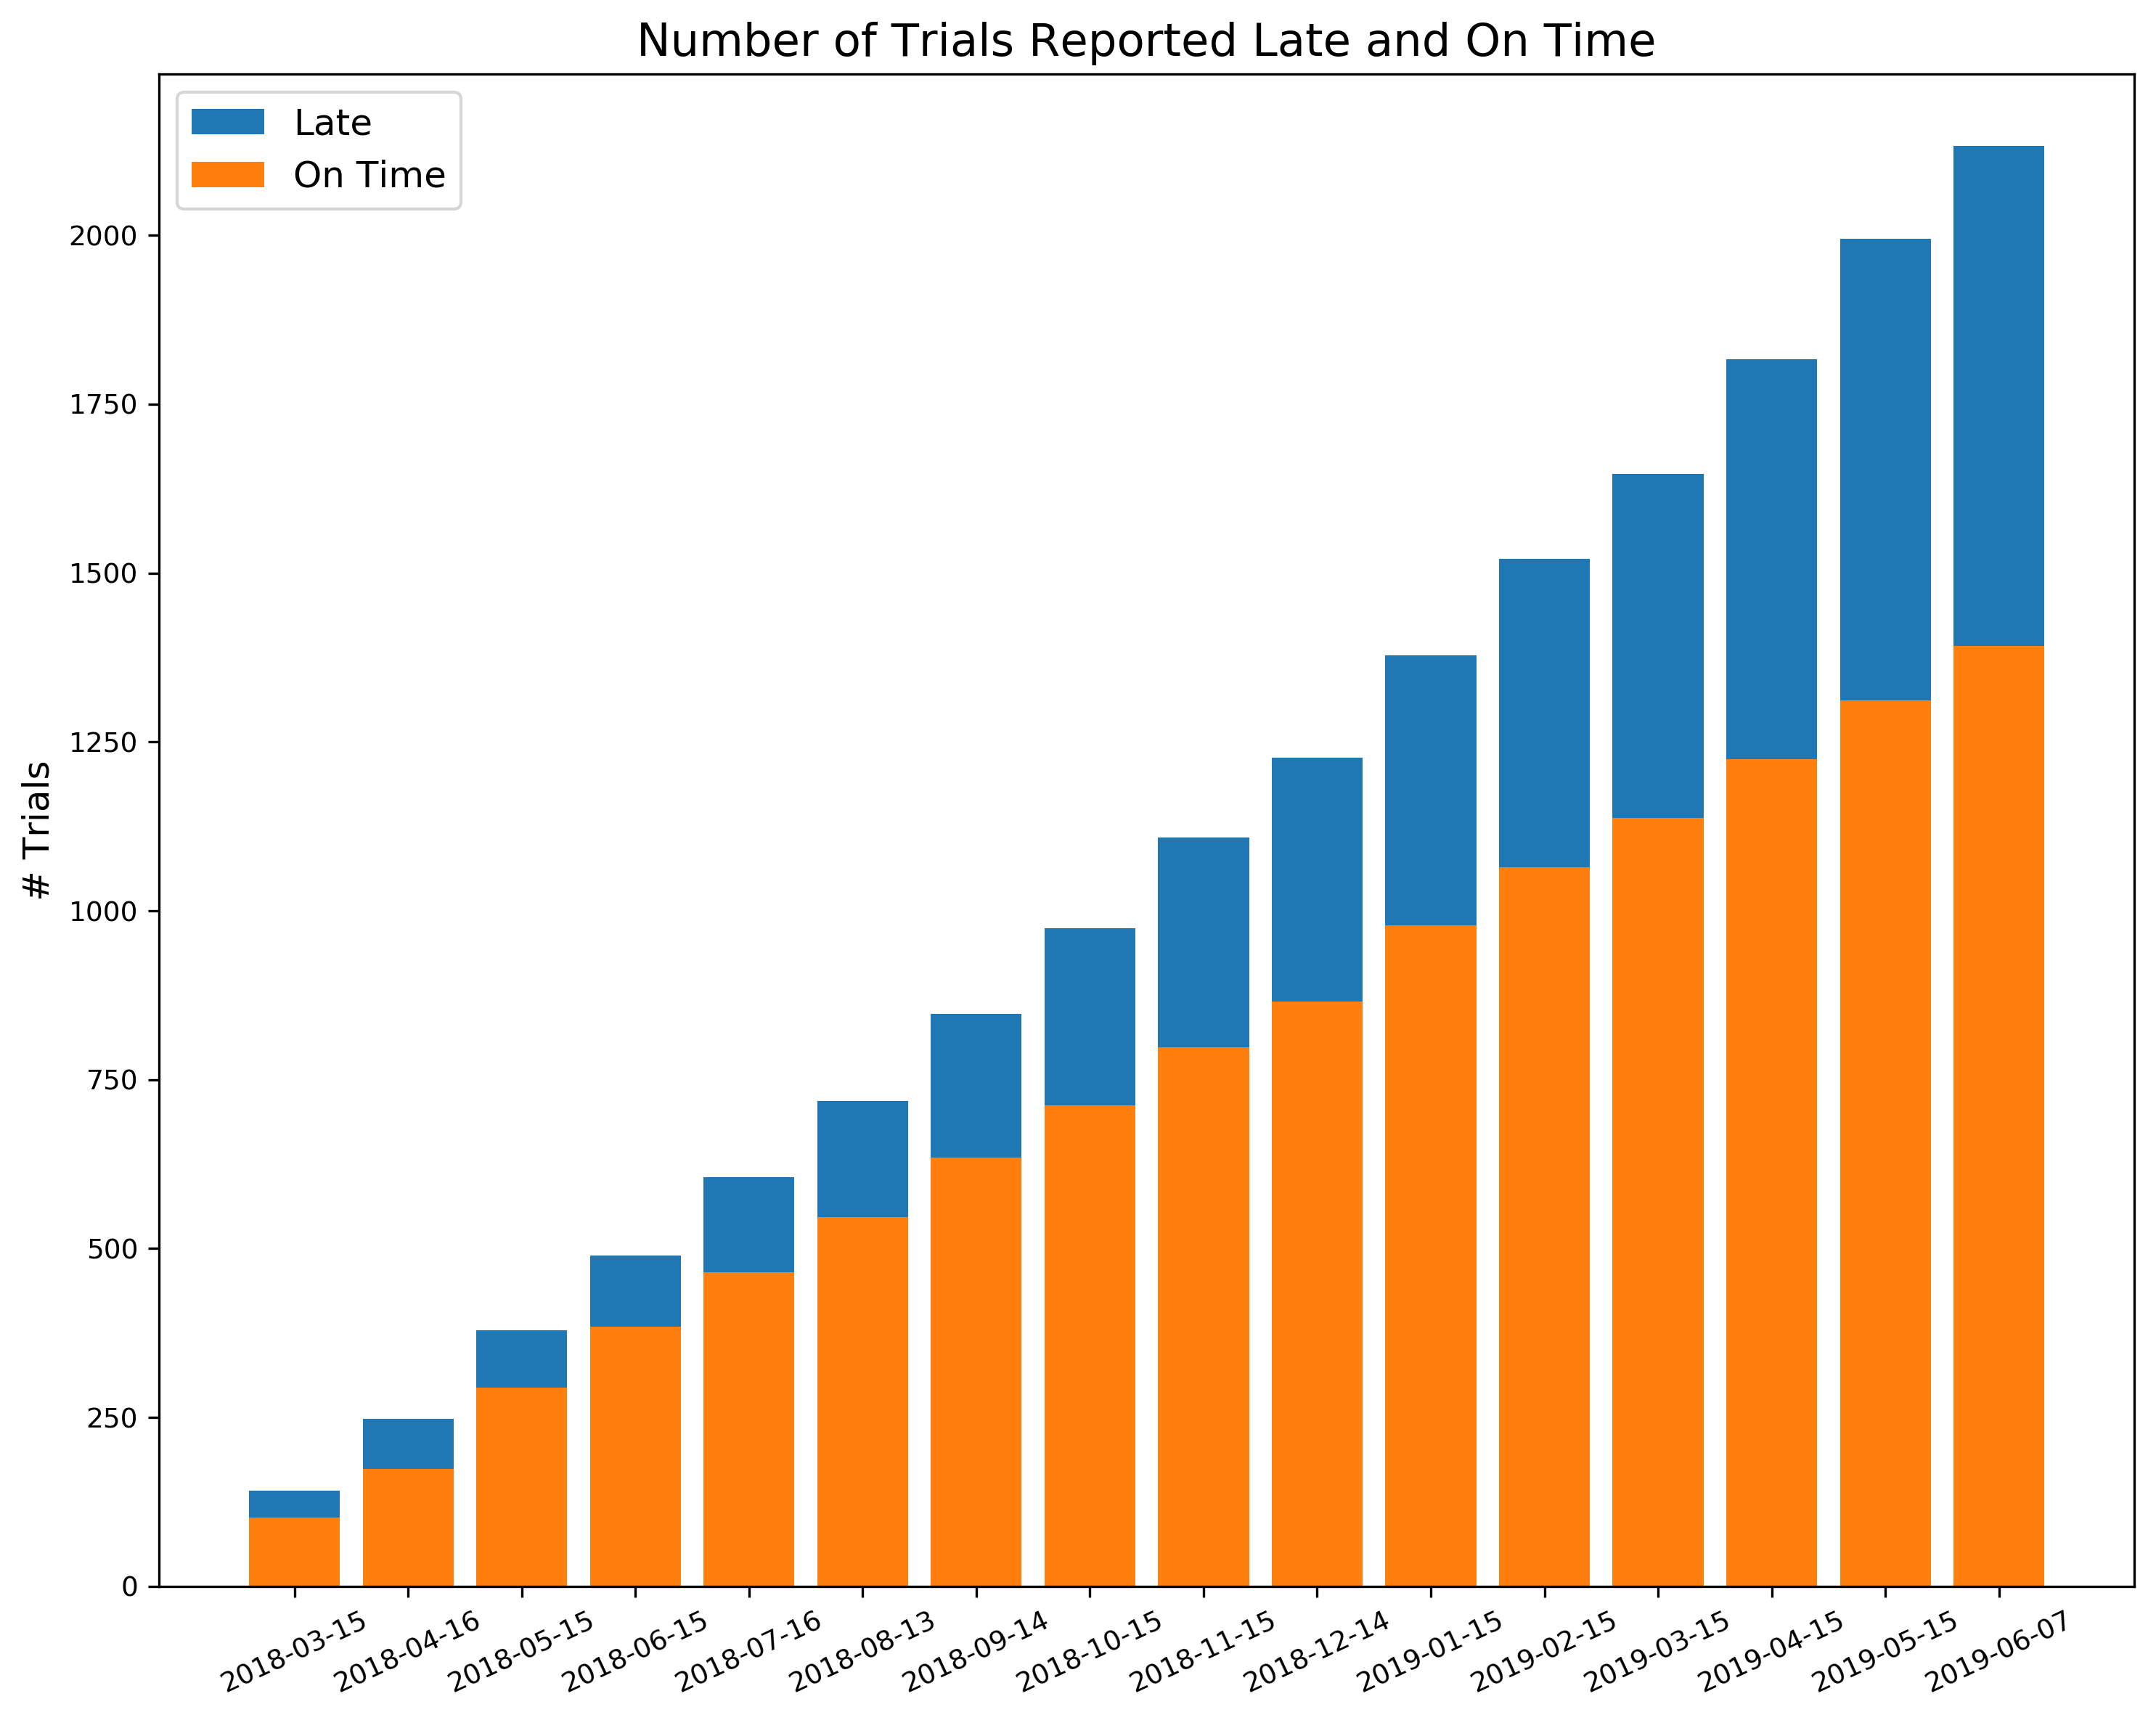

In [9]:
#Creates a bar graph of the number of trials reported each month, and the amount that was reported late, and the amount that was
#reported on time.

#Likely to Delete this in favor of below line graph

ind = range(0,len(reported_by_month_all),1)
fig, ax = plt.subplots(figsize=(10,8), dpi=300)
p1 = plt.bar(ind, reported_by_month_all)
p2 = plt.bar(ind, reported_by_month_on_time)
plt.title("Number of Trials Reported Late and On Time", fontsize = 15)
plt.ylabel('# Trials', fontsize=12)
plt.legend((p1, p2), ("Late","On Time"),fontsize=12)
plt.xticks(ind, scrape_dates, rotation = '25', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

In [10]:
#calculates percents for reporting on-time.
prct_on_time = []
for a, b, in zip(reported_by_month_on_time, reported_by_month_all):
    prct_on_time.append(round((a/b)*100,2))
print(prct_on_time)

[71.83, 70.16, 77.57, 78.37, 76.73, 76.08, 74.97, 73.1, 71.96, 70.58, 71.04, 70.02, 69.03, 67.4, 65.76, 65.29]


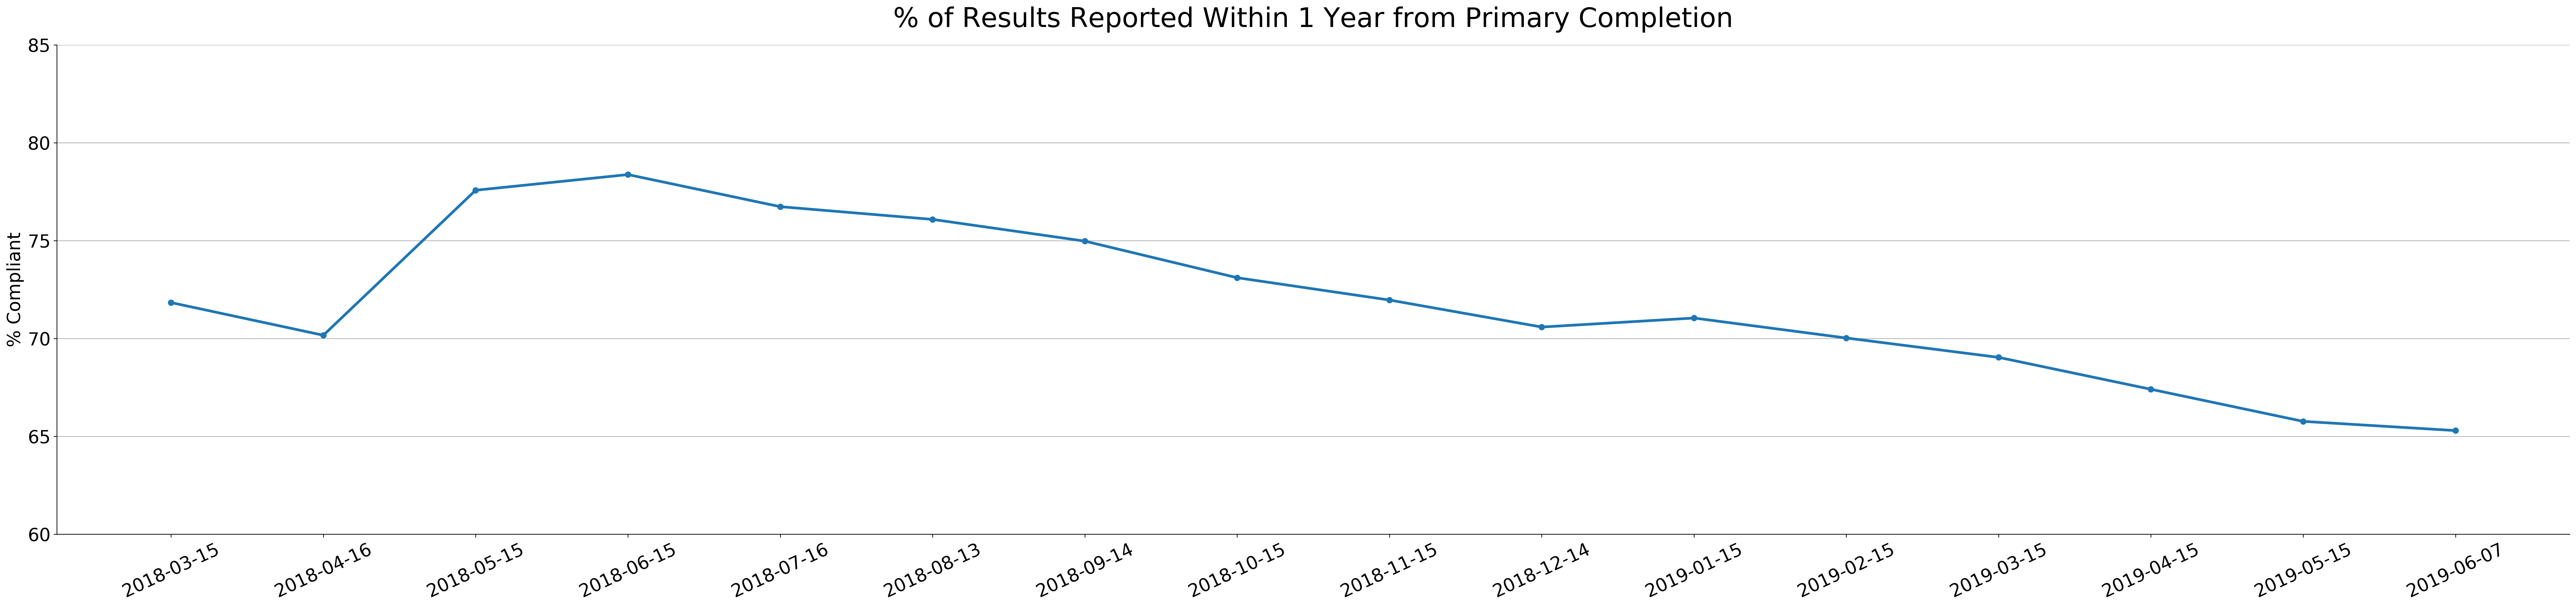

In [19]:
#Creates a line graph for reporting on time

fig, ax = plt.subplots(figsize=(50,10), dpi = 300)
index = np.arange(len(scrape_dates))
plt.plot(index, prct_on_time, lw=3, marker = "o")
plt.tick_params(axis='both', which='major', labelsize=20)
plt.ylabel('% Compliant', fontsize=20)
plt.xticks(index, scrape_dates, rotation=25)
plt.title("% of Results Reported Within 1 Year from Primary Completion", pad = 20, fontsize = 30)
plt.grid(axis='y')
ax.set_ylim([60,85])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

# Ranked Sponsors

Ranking of all sponsors reporting for covered trials

In [ ]:
#df = pd.read_csv('C:/Users/ndevito/Desktop/FDAAA Implementation Data/Processed CSVs/applicable_trials_2019-06-07.csv')
df = pd.read_csv('/Users/nicholasdevito/Desktop/fdaaa analysis/clinicaltrials_raw_clincialtrials_json_2019-06-07.csv')

cols = ['nct_id', 'results_due', 'has_results', 'pending_results', 'due_date', 'available_completion_date', 
        'first_results_submission_any', 'sponsor']

rankings_df = df[cols][df.results_due == 1].reset_index(drop=True)
rankings_df['reported_late'] = np.where(((rankings_df.due_date < rankings_df.first_results_submission_any) & 
                                         rankings_df.first_results_submission_any.notnull()), 1, 0)

In [ ]:
grouped_spon = rankings_df.groupby(by='sponsor').sum()
grouped_spon['reported'] = grouped_spon.has_results + grouped_spon.pending_results
grouped_spon['reporting_prct'] = (grouped_spon.reported / grouped_spon.results_due) * 100

In [ ]:
grouped_spon.sort_values(by='results_due', ascending=False, inplace=True)

In [ ]:
#full dataset to filter/export as needed
grouped_spon.head()

# Reporting Survivorship

Developing Kaplan-Meier curves for analysis of how long it takes trials to report once they become due.

In [23]:
#reading in the processed data for just 7 June 2019
#df = pd.read_csv('C:/Users/ndevito/Desktop/FDAAA Implementation Data/Processed CSVs/applicable_trials_2019-06-07.csv')
df = pd.read_csv('/Users/nicholasdevito/Desktop/fdaaa analysis/processed data/applicable_trials_2019-06-07.csv')


#Fixing a specific data error confirmed with clinicaltrials.gov in which a QC date was incorrect in the data
#In the raw data, the "Results First Submitted" date occured after the "Results First Posted" date which is impossible
#This was corrected on ClinicalTrials.gov as of 12 June 2019 and the below correction reflects this corrected data
#https://clinicaltrials.gov/ct2/keydates/NCT02544607
ix = df.index[df.nct_id == 'NCT02544607'].tolist()[0]
df.at[ix, 'results_first_posted_date'] = '04/04/2019'

In [24]:
#Taking only columns needed
reporting_surv = df[['nct_id', 'results_due', 'has_results', 'pending_results', 'due_date', 'available_completion_date', 
                'first_results_submission_any', 'sponsor_type']][df.results_due == 1].reset_index(drop=True)

#Creating columns necessary for analysis
#Denotes if a trial has reported whether actual results are available or not
reporting_surv['reported'] = np.where(((reporting_surv.has_results==1) | (reporting_surv.pending_results ==1)), 1, 0)
#Static column for the fixed date the data was pulled
reporting_surv['scrape_date'] = pd.datetime(2019,6,7)

#Getting dates into date format
reporting_surv['due_date'] = pd.to_datetime(reporting_surv['due_date'], format = '%Y-%m-%d')
reporting_surv['available_completion_date'] = pd.to_datetime(reporting_surv['available_completion_date'], format = '%Y-%m-%d')
reporting_surv['first_results_submission_any'] = pd.to_datetime(reporting_surv['first_results_submission_any'], format = '%Y-%m-%d')

In [25]:
#data for if you want to do survivorship analysis from when trials become due
reporting_surv['days_late'] = (reporting_surv.first_results_submission_any - reporting_surv.due_date) / pd.Timedelta('1 day')
reporting_surv['censored_due'] = (reporting_surv.scrape_date - reporting_surv.due_date) / pd.Timedelta('1 day')
reporting_surv.loc[reporting_surv['reported'] == 1, 'censored_due'] = None
reporting_surv['duration_due'] = np.where(reporting_surv.censored_due.notnull(), reporting_surv.censored_due, reporting_surv.days_late)
reporting_surv['duration_due'] = np.where(reporting_surv['duration_due'] < 0, 0, reporting_surv['duration_due'])

#data for if you want to do survivorship analysis from when the trial reached primary completion
reporting_surv['days_from_completion'] = (reporting_surv.first_results_submission_any - reporting_surv.available_completion_date) / pd.Timedelta('1 day')
reporting_surv['censored_completion'] = (reporting_surv.scrape_date - reporting_surv.available_completion_date) / pd.Timedelta('1 day')
reporting_surv.loc[reporting_surv['reported'] == 1, 'censored_completion'] = None
reporting_surv['duration_completion'] = np.where(reporting_surv.censored_completion.notnull(), reporting_surv.censored_completion, reporting_surv.days_from_completion)
reporting_surv['duration_completion'] = np.where(reporting_surv['duration_completion'] < 0, 0, reporting_surv['duration_completion'])

#For both of these examples, a trial that reports before relevant date (due or completion)
#is defaulted to being reported at 0 days.

In [26]:
#pulling out the latest reporting trial
reporting_surv.loc[reporting_surv['censored_completion'].idxmax()]

nct_id                                  NCT02251236
results_due                                       1
has_results                                       0
pending_results                                   0
due_date                        2018-01-18 00:00:00
available_completion_date       2017-01-18 00:00:00
first_results_submission_any                    NaT
sponsor_type                                  Other
reported                                          0
scrape_date                     2019-06-07 00:00:00
days_late                                       NaN
censored_due                                    505
duration_due                                    505
days_from_completion                            NaN
censored_completion                             870
duration_completion                             870
Name: 3084, dtype: object

Median time to report: 422.0 days


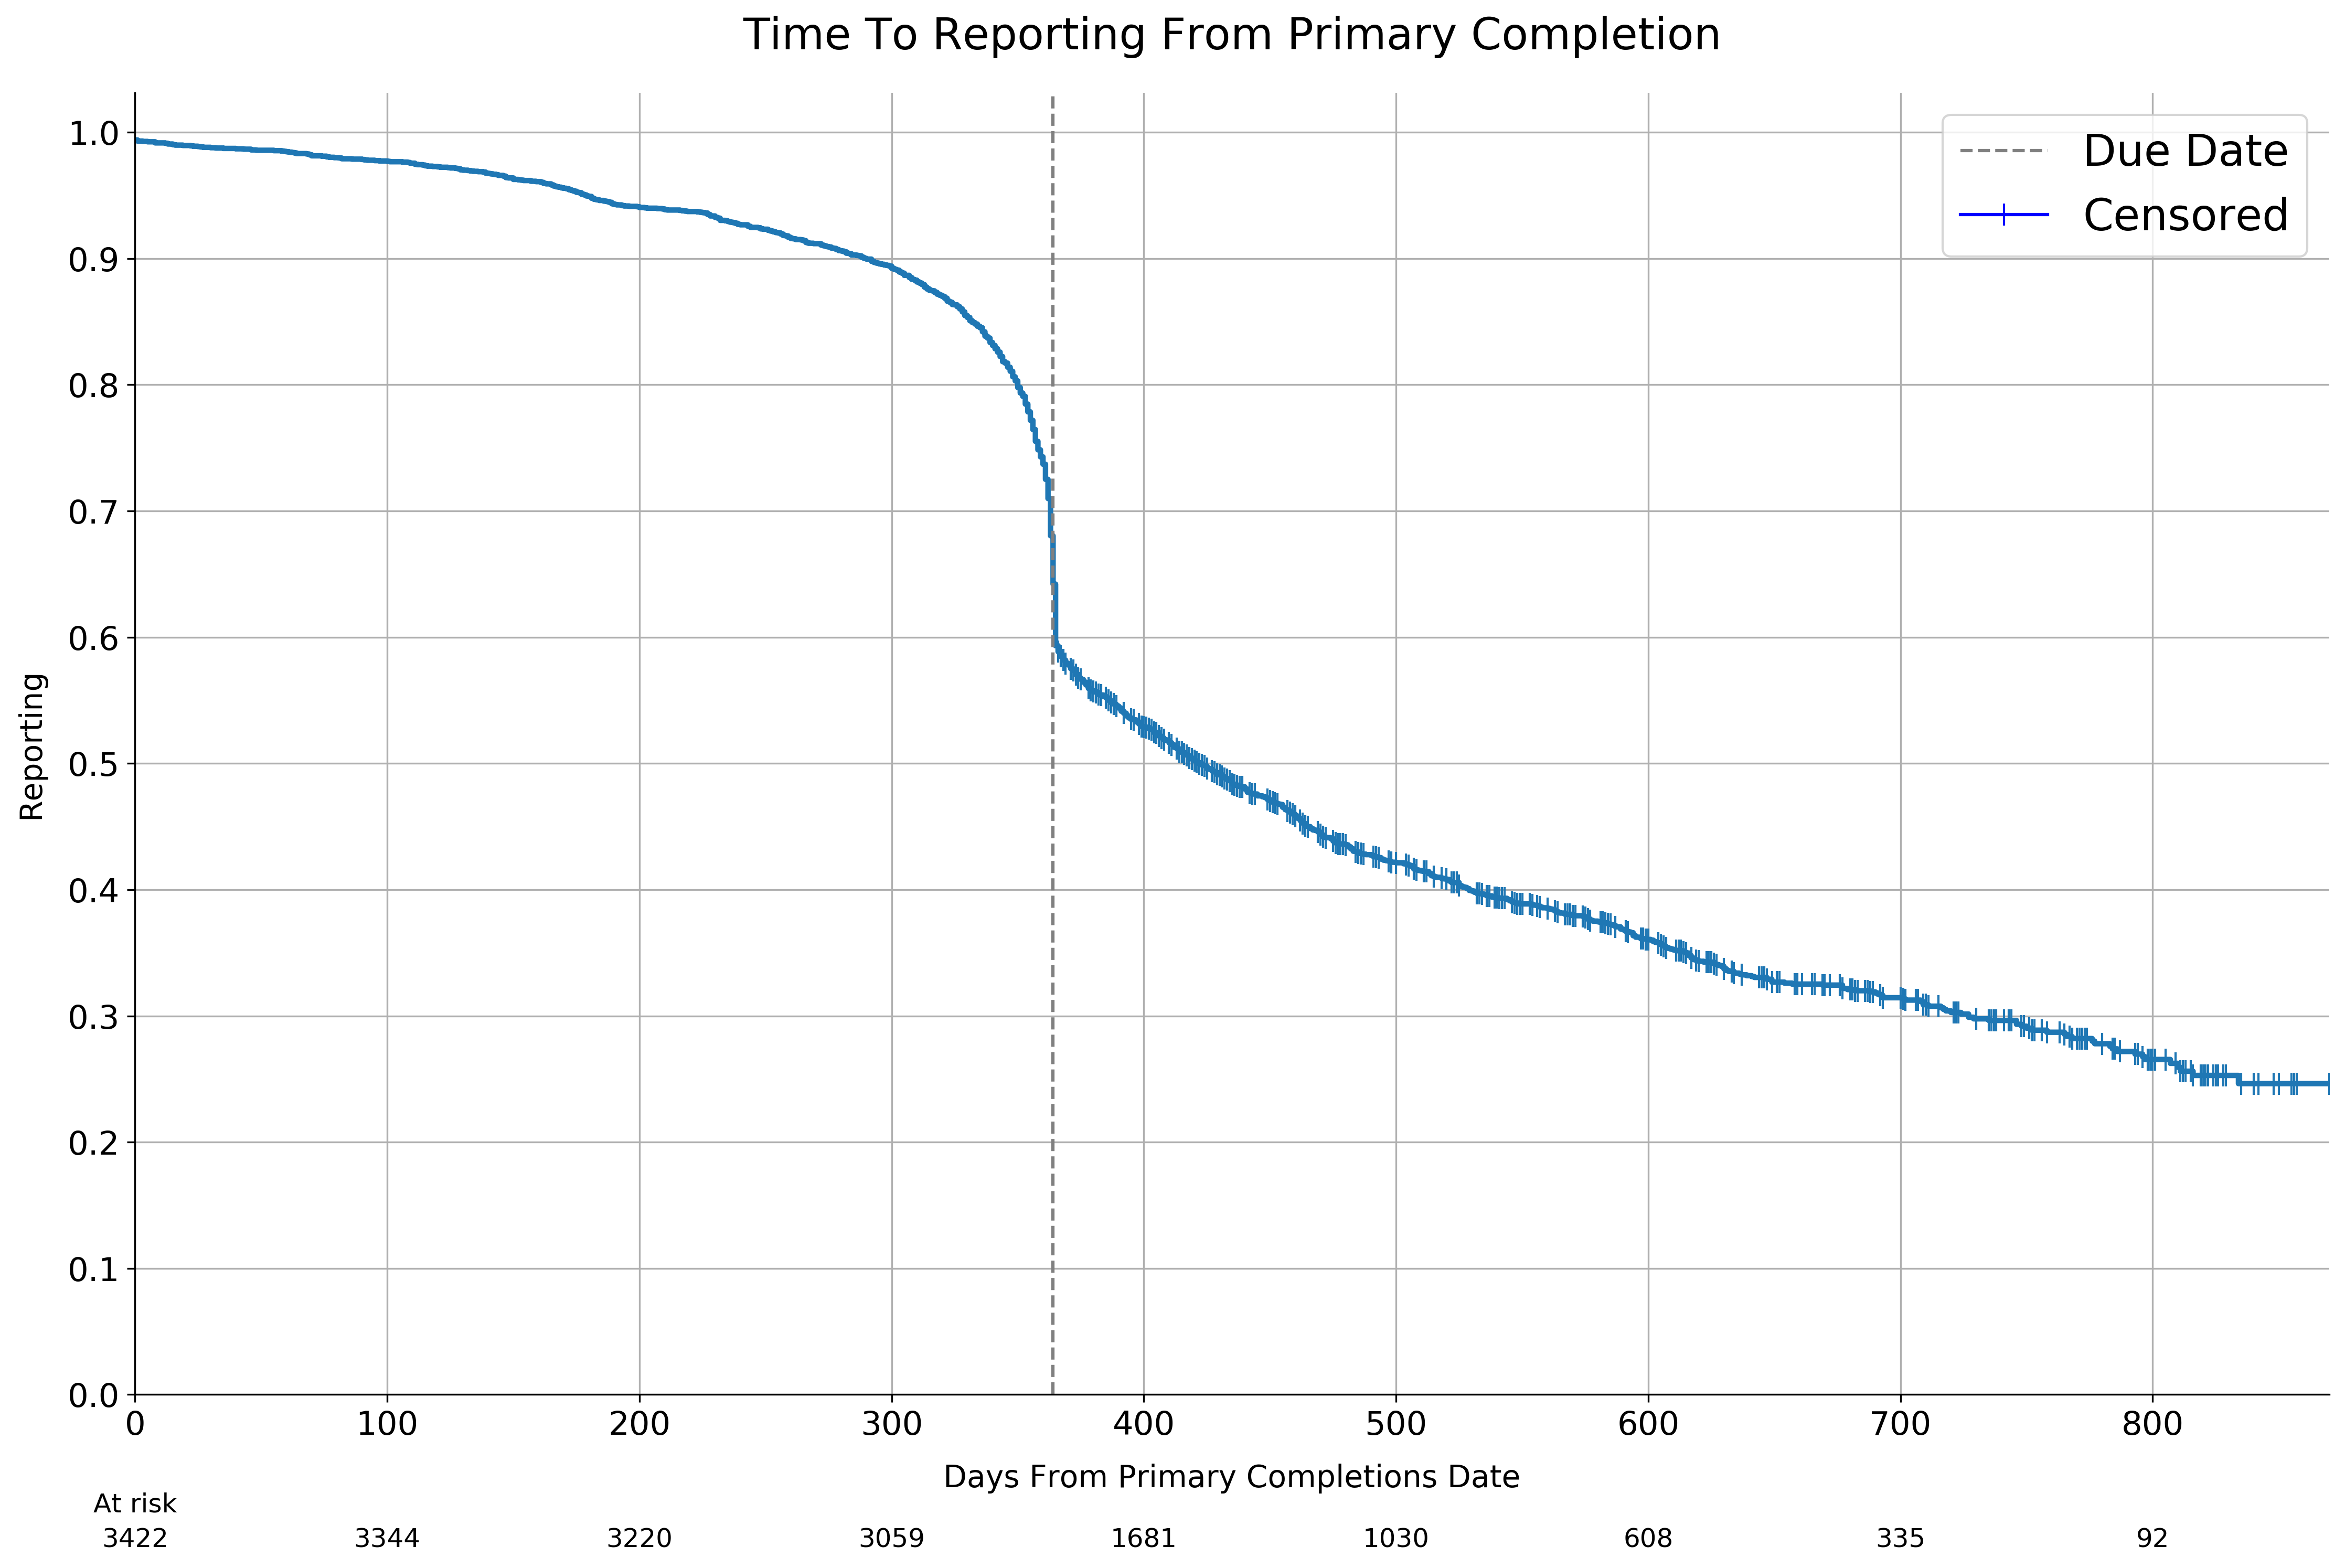

In [27]:
#importing the adjusted function for fixing bug in displaying at risk counts.
from lifelines_fix import add_at_risk_counts

#KM Curve for reporting from primary completion date. Dotted line represents the "due date" of 1 year after completion
yticks = list(np.arange(0,1.1,.1))
fig = plt.figure(dpi=300)
ax = plt.subplot()

kmf_overall = KaplanMeierFitter()
kmf_overall.fit(reporting_surv.duration_completion, reporting_surv["reported"])
print('Median time to report: {} days'.format(kmf_overall.median_))
#ax = kmf_overall.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax =  kmf_overall.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)


ax.axvline(x=364, color='grey', ls='--')
plt.title("Time To Reporting From Primary Completion", pad=20, fontsize=20)
plt.ylabel('Reporting', labelpad=10, fontsize=14)
plt.xlabel('Days From Primary Completions Date', labelpad=10, fontsize=14)

ax.tick_params(labelsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
add_at_risk_counts(12, kmf_overall, labels=None)

leg_1 = Line2D([0], [0], color='grey', ls='--')
leg_2 = Line2D([0], [0], color='blue', marker='|', ms=10)
leg = [leg_1, leg_2]
leg_lab = ['Due Date', 'Censored']

plt.legend(leg, leg_lab, fontsize=20)
plt.show()
#plt.savefig('survival_with_censor.png')

In [28]:
#Run this cell to check the KM estimate at any day
print(kmf_overall.survival_function_.loc[796]['KM_estimate'])
print(kmf_overall.survival_function_.loc[800]['KM_estimate'])

0.2676021722400458
0.26546135486212535


In [29]:
kmf_overall.survival_function_

,KM_estimate
timeline,
0.0,0.993863
1.0,0.992987
3.0,0.992694
5.0,0.992402
8.0,0.991525
12.0,0.991233
13.0,0.990649
15.0,0.990064
16.0,0.989772


Median time to report for Industry: 367.0 days
Median time to report for Non-industry: 456.0 days


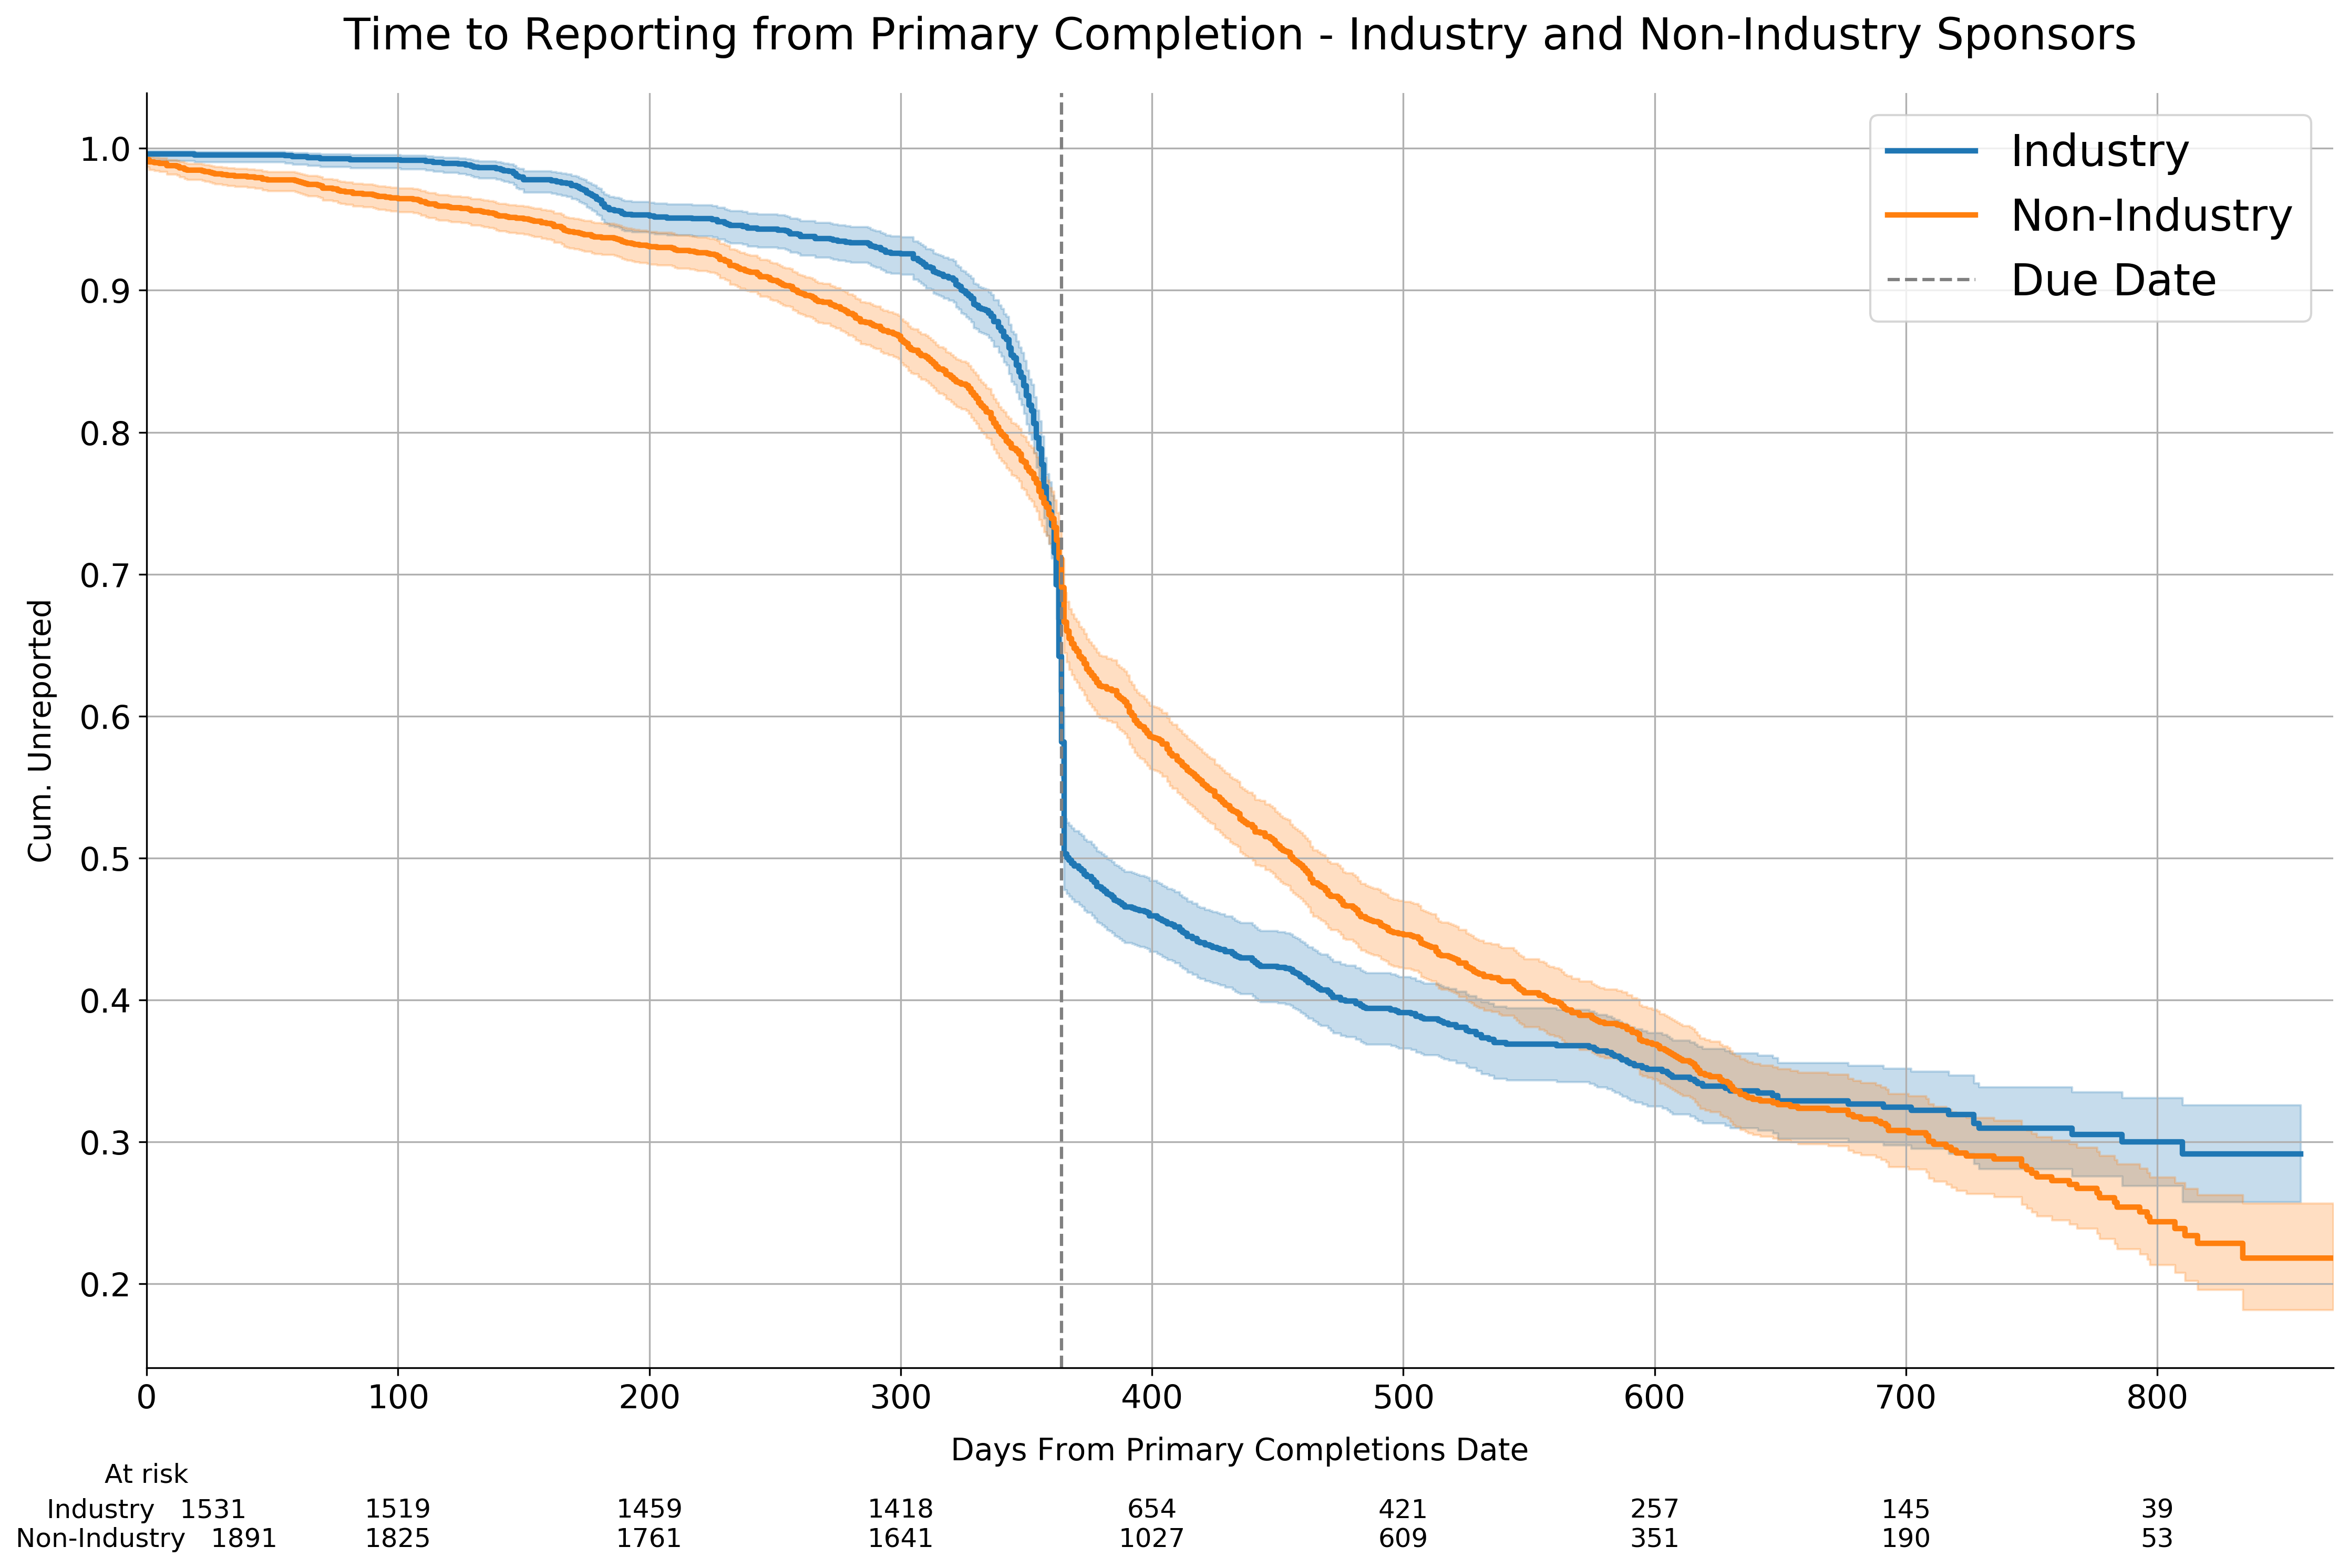

In [30]:
yticks = list(np.arange(0,1.1,.1))
fig = plt.figure(dpi=300)
ax = plt.subplot()

kmf_ind = KaplanMeierFitter()
kmf_ind.fit(reporting_surv.duration_completion[reporting_surv.sponsor_type == 'Industry'], reporting_surv["reported"][reporting_surv.sponsor_type == 'Industry'], label = 'Industry')
print('Median time to report for Industry: {} days'.format(kmf_ind.median_))
ax = kmf_ind.plot(ci_show=True, yticks=yticks, figsize=(15,10), grid=True, lw = 2.5, ax=ax)


kmf_non_ind = KaplanMeierFitter()
kmf_non_ind.fit(reporting_surv.duration_completion[reporting_surv.sponsor_type != 'Industry'], reporting_surv["reported"][reporting_surv.sponsor_type != 'Industry'], label = 'Non-Industry')
print('Median time to report for Non-industry: {} days'.format(kmf_non_ind.median_))
ax = kmf_non_ind.plot(ci_show=True, yticks=yticks, figsize=(15,10), grid=True, ax=ax, lw = 2.5)
plt.ylabel('Cum. Unreported', labelpad=10, fontsize=14)
plt.xlabel('Days From Primary Completions Date', labelpad=10, fontsize=14)
plt.title('Time to Reporting from Primary Completion - Industry and Non-Industry Sponsors', pad=20, fontsize = 20)

ax.axvline(x=364, color='grey', ls='--', label = 'Due Date')
ax.legend(fontsize = 20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelsize=15)

plt.legend(fontsize=20)

add_at_risk_counts(12, kmf_ind, kmf_non_ind)
plt.show()

Median time to report: 370.0 days


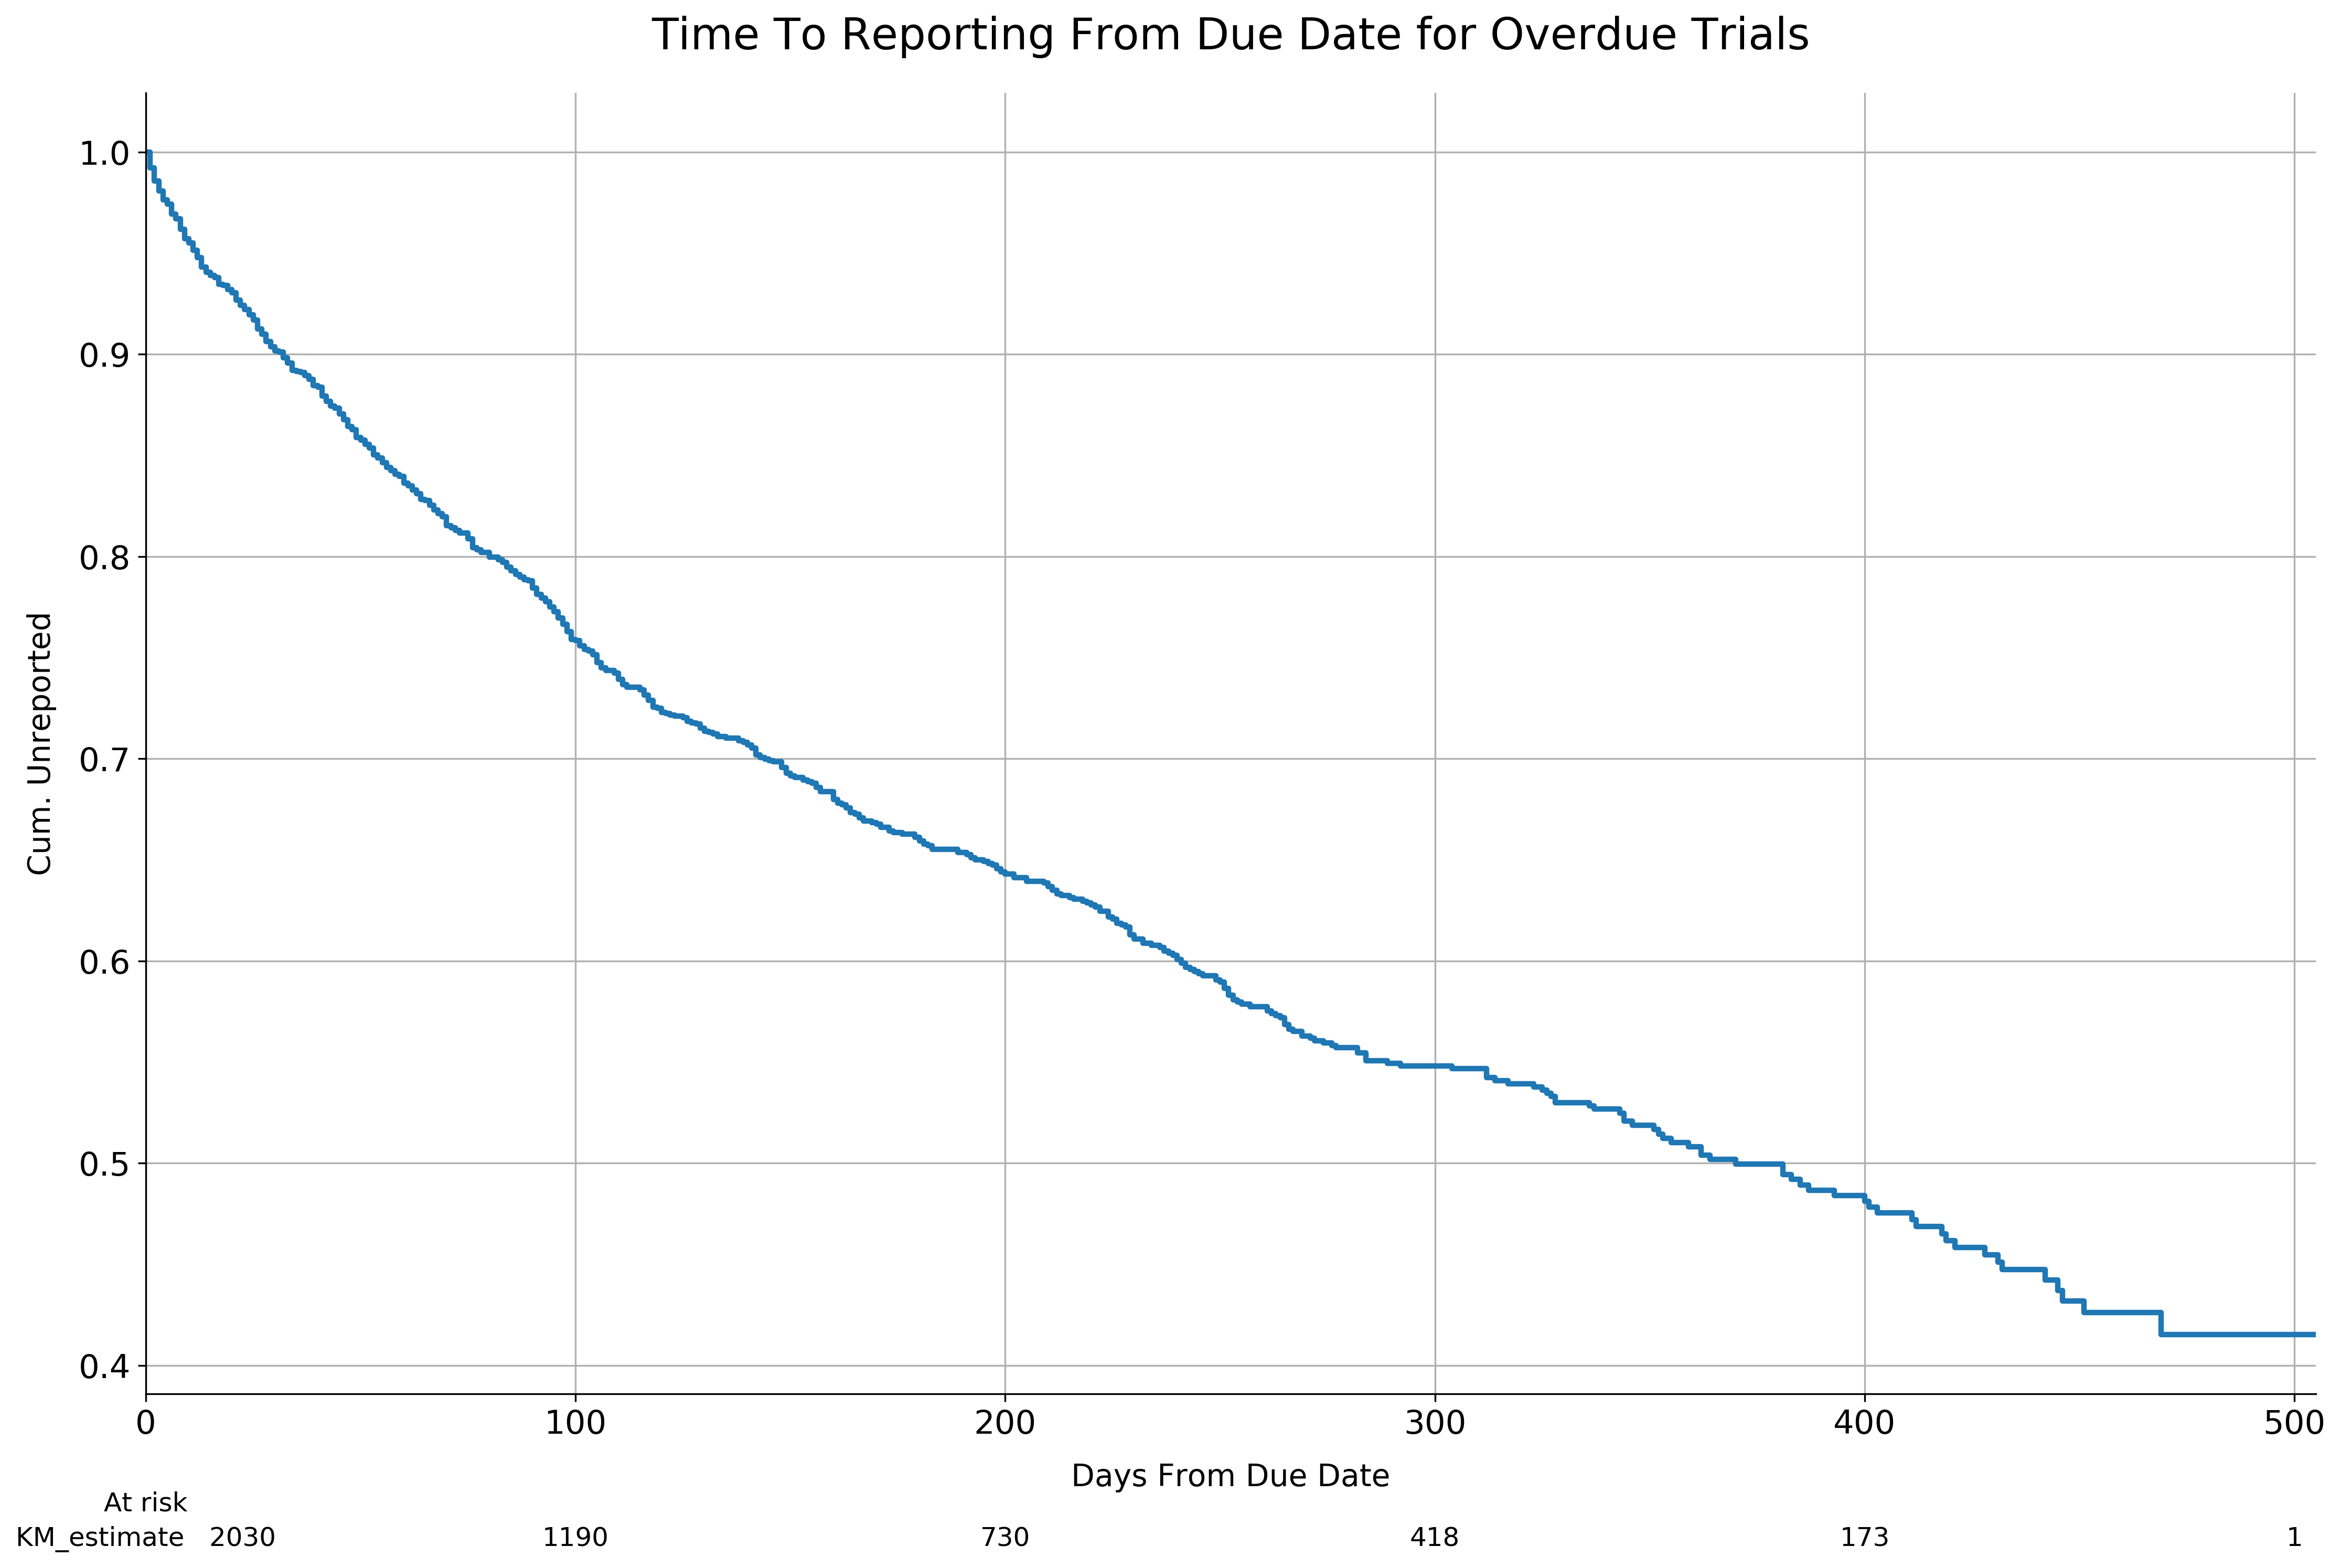

In [31]:
#Zooming in on only the survival of only trials that are overdue

#Looking at only trials that become overdue
reporting_surv_due = reporting_surv[(reporting_surv.due_date < reporting_surv.first_results_submission_any) | 
                                    (reporting_surv.first_results_submission_any.isnull())]

fig = plt.figure(dpi=300)
ax = plt.subplot()

kmf_due = KaplanMeierFitter()
kmf_due.fit(reporting_surv_due.duration_due, reporting_surv_due["reported"])

ax = kmf_due.plot(ci_show=False, figsize=(15,10), grid=True, legend=False, ax=ax, lw=2.5)

plt.ylabel('Cum. Unreported', labelpad=10, fontsize=14)
plt.xlabel('Days From Due Date', labelpad=10, fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelsize=15)
plt.title("Time To Reporting From Due Date for Overdue Trials", pad=20, fontsize = 20)

add_at_risk_counts(12, kmf_due)
print('Median time to report: {} days'.format(kmf_due.median_))
plt.show()

Median time to report for Industry: inf days
Median time to report for Industry: 271.0 days


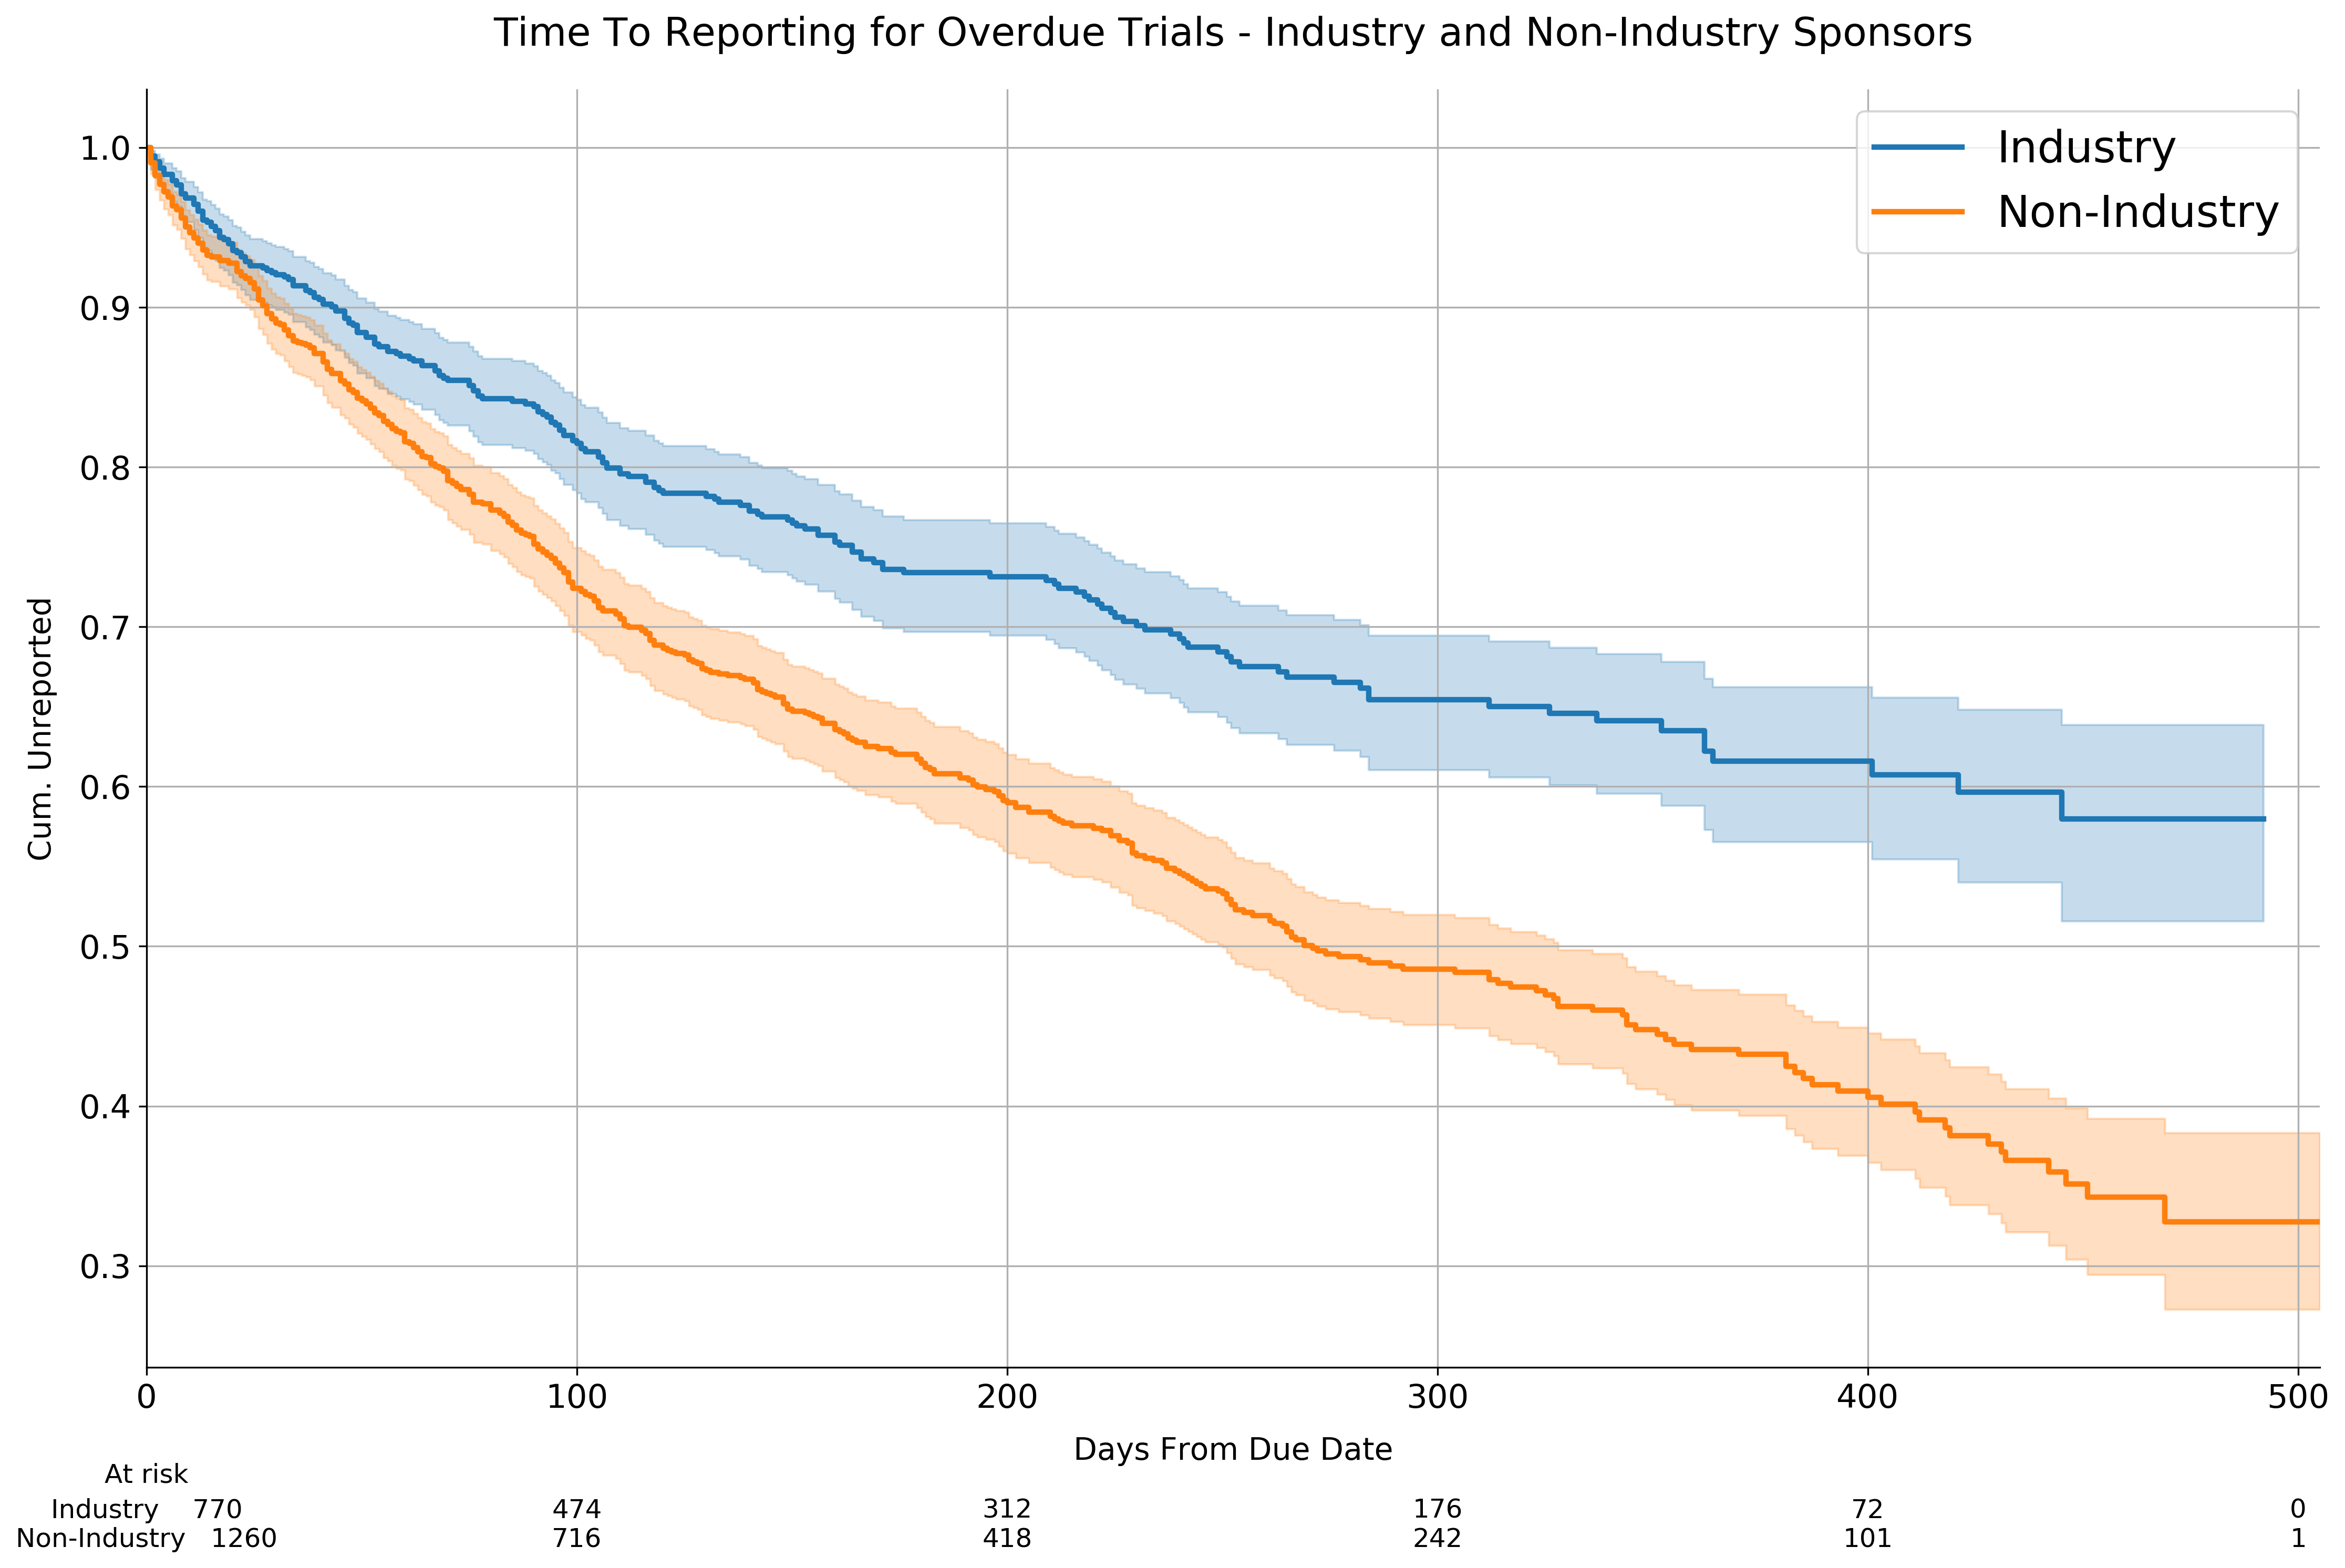

In [32]:
fig = plt.figure(dpi=300)
ax = plt.subplot()

kmf_ind_due = KaplanMeierFitter()

kmf_ind_due.fit(reporting_surv_due.duration_due[reporting_surv_due.sponsor_type == 'Industry'], 
        reporting_surv_due["reported"][reporting_surv_due.sponsor_type == 'Industry'], label = 'Industry')
ax = kmf_ind_due.plot(ci_show=True, figsize=(15,10), grid=True, lw = 2.5, ax=ax)

kmf_non_ind_due = KaplanMeierFitter()
kmf_non_ind_due.fit(reporting_surv_due.duration_due[reporting_surv_due.sponsor_type != 'Industry'], 
        reporting_surv_due["reported"][reporting_surv_due.sponsor_type != 'Industry'], label = 'Non-Industry')
ax = kmf_non_ind_due.plot(ci_show=True, figsize=(15,10), grid=True, lw = 2.5, ax=ax)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelsize=15)
plt.title("Time To Reporting for Overdue Trials - Industry and Non-Industry Sponsors", pad=20, fontsize = 18)
plt.ylabel('Cum. Unreported', labelpad=10, fontsize=14)
plt.xlabel('Days From Due Date', labelpad=10, fontsize=14)
ax.legend(fontsize = 20)

print('Median time to report for Industry: {} days'.format(kmf_ind_due.median_))
print('Median time to report for Industry: {} days'.format(kmf_non_ind_due.median_))

add_at_risk_counts(12, kmf_ind_due, kmf_non_ind_due)
plt.show()

In [ ]:
from lifelines.statistics import logrank_test

results = logrank_test(reporting_surv_due.duration_due[reporting_surv_due.sponsor_type == 'Industry'], 
                      reporting_surv_due.duration_due[reporting_surv_due.sponsor_type != 'Industry'],
                      reporting_surv_due["reported"][reporting_surv_due.sponsor_type == 'Industry'],
                      reporting_surv_due["reported"][reporting_surv_due.sponsor_type != 'Industry'])

results.print_summary()